In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.glmm import GLMMEncoder
from category_encoders.polynomial import PolynomialEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

sns.set()

Загрузка данных первого сета.

In [2]:
cars_global = pd.read_csv('car.data', names=["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"])
#Смотрим основные параметры.

FileNotFoundError: [Errno 2] No such file or directory: 'glass.data'

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [51]:
cars_global.head(100)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
95,vhigh,vhigh,5more,4,med,high,unacc
96,vhigh,vhigh,5more,4,big,low,unacc
97,vhigh,vhigh,5more,4,big,med,unacc
98,vhigh,vhigh,5more,4,big,high,unacc


Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [52]:
cars_global.count()

buying      1728
maint       1728
doors       1728
persons     1728
lug_boot    1728
safety      1728
class       1728
dtype: int64

В процентном соотношении.

In [53]:
for col in cars_global.columns:
    pct_missing = np.mean(cars_global[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {cars_global[col].min()}     max:{cars_global[col].max()}')

buying - 0.0     min: high     max:vhigh
maint - 0.0     min: high     max:vhigh
doors - 0.0     min: 2     max:5more
persons - 0.0     min: 2     max:more
lug_boot - 0.0     min: big     max:small
safety - 0.0     min: high     max:med
class - 0.0     min: acc     max:vgood


In [54]:
def test_encoder(encoder):
    cars = cars_global.copy()
    encoder.fit(cars, target)
    cars = encoder.transform(cars)
    datasets = {"train": {}, "test": {}}
    datasets["train"]["data"], datasets["test"]["data"], datasets["train"]["target"], datasets["test"][
        "target"] = train_test_split(cars, target, train_size=0.868055555556, shuffle=True)

    # Попробуем прогнать нашу же модель KNeighborsClassifier через подборку лучших гиперпараметров.

    parameters = {"n_neighbors": (3, 4, 5, 6, 7, 8, 9), "weights": ("uniform", "distance"),
                  "algorithm": ("ball_tree", "kd_tree", "brute"), "p": [1, 2]}
    clf = GridSearchCV(KNeighborsClassifier(), parameters)
    clf.fit(datasets["train"]["data"], datasets["train"]["target"])
    prediction_test = clf.predict(datasets["test"]["data"])
    print(clf.get_params())
    # Считаем метрики
    mse = mean_squared_error(datasets["test"]["target"], prediction_test)
    accuracy = metrics.accuracy_score(datasets["test"]["target"], prediction_test)
    balanced_accuracy = metrics.balanced_accuracy_score(datasets["test"]["target"], prediction_test)
    precision = metrics.precision_score(datasets["test"]["target"], prediction_test, average='weighted')
    recall = metrics.recall_score(datasets["test"]["target"], prediction_test, average='weighted')

    return [cars, mse, round(precision, 2), round(recall, 2), round(accuracy, 2), round(balanced_accuracy, 2)]

ROC curve:

In [55]:
target_encoder = preprocessing.LabelEncoder()
target = target_encoder.fit_transform(cars_global["class"])

cars_global.drop(columns=["class"], inplace=True)

In [56]:
print("Metrics for encoder 'Target Encoder': ")
target_encoder_result = test_encoder(TargetEncoder())

Metrics for encoder 'Target Encoder': 
{'cv': None, 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None, 'param_grid': {'n_neighbors': (3, 4, 5, 6, 7, 8, 9), 'weights': ('uniform', 'distance'), 'algorithm': ('ball_tree', 'kd_tree', 'brute'), 'p': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


In [ ]:
target_encoder_result.pop(0)

In [64]:
print("Data after encoder 'Sum Encoder': ")
sum_encoder_result = test_encoder(SumEncoder())

Data after encoder 'Sum Encoder': 


/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


In [65]:
sum_encoder_result.pop(0)

,intercept,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,persons_1,lug_boot_0,lug_boot_1,safety_0,safety_1
0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,-1.0
3,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,0.0,1.0
1724,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0
1725,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0
1726,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0


In [80]:
print("Data after encoder 'M Estimate Encoder': ")
m_estimator_encoder_result =test_encoder(MEstimateEncoder())

Data after encoder 'M Estimate Encoder': 


In [81]:
m_estimator_encoder_result.pop(0)

,buying,maint,doors,persons,lug_boot,safety
0,1.666405,1.666405,1.613287,1.999226,1.598879,1.999226
1,1.666405,1.666405,1.613287,1.999226,1.598879,1.307718
2,1.666405,1.666405,1.613287,1.999226,1.598879,1.352779
3,1.666405,1.666405,1.613287,1.999226,1.533021,1.999226
4,1.666405,1.666405,1.613287,1.999226,1.533021,1.307718
...,...,...,...,...,...,...
1723,1.571716,1.527837,1.532456,1.357978,1.533021,1.307718
1724,1.571716,1.527837,1.532456,1.357978,1.533021,1.352779
1725,1.571716,1.527837,1.532456,1.357978,1.527822,1.999226
1726,1.571716,1.527837,1.532456,1.357978,1.527822,1.307718


In [70]:
print("Data after encoder 'Leave One Out Encoder': ")
leave_one_out_encoder_result = test_encoder(LeaveOneOutEncoder())

Data after encoder 'Leave One Out Encoder': 


In [79]:
leave_one_out_encoder_result.pop(0)

,buying,maint,doors,persons,lug_boot,safety
0,1.666667,1.666667,1.613426,2.000000,1.598958,2.000000
1,1.666667,1.666667,1.613426,2.000000,1.598958,1.307292
2,1.666667,1.666667,1.613426,2.000000,1.598958,1.352431
3,1.666667,1.666667,1.613426,2.000000,1.532986,2.000000
4,1.666667,1.666667,1.613426,2.000000,1.532986,1.307292
...,...,...,...,...,...,...
1723,1.571759,1.527778,1.532407,1.357639,1.532986,1.307292
1724,1.571759,1.527778,1.532407,1.357639,1.532986,1.352431
1725,1.571759,1.527778,1.532407,1.357639,1.527778,2.000000
1726,1.571759,1.527778,1.532407,1.357639,1.527778,1.307292


In [71]:
print("Data after encoder 'Helmert Encoder': ")
helmert_encoder_result = test_encoder(HelmertEncoder())

Data after encoder 'Helmert Encoder': 


/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


In [82]:
helmert_encoder_result.pop(0)

,intercept,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,persons_1,lug_boot_0,lug_boot_1,safety_0,safety_1
0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,2.0
3,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,1,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,2.0,1.0,-1.0,1.0,-1.0
1724,1,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,2.0,1.0,-1.0,0.0,2.0
1725,1,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,-1.0,-1.0
1726,1,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,1.0,-1.0


In [72]:
print("Data after encoder 'Cat Boost Encoder': ")
cat_boost_encoder_result = test_encoder(CatBoostEncoder())

Data after encoder 'Cat Boost Encoder': 


In [83]:
cat_boost_encoder_result.pop(0)

,buying,maint,doors,persons,lug_boot,safety
0,1.666405,1.666405,1.613287,1.999226,1.598879,1.999226
1,1.666405,1.666405,1.613287,1.999226,1.598879,1.307718
2,1.666405,1.666405,1.613287,1.999226,1.598879,1.352779
3,1.666405,1.666405,1.613287,1.999226,1.533021,1.999226
4,1.666405,1.666405,1.613287,1.999226,1.533021,1.307718
...,...,...,...,...,...,...
1723,1.571716,1.527837,1.532456,1.357978,1.533021,1.307718
1724,1.571716,1.527837,1.532456,1.357978,1.533021,1.352779
1725,1.571716,1.527837,1.532456,1.357978,1.527822,1.999226
1726,1.571716,1.527837,1.532456,1.357978,1.527822,1.307718


In [73]:
print("Data after encoder 'James Stein Encoder': ")
james_stein_encoder = test_encoder(JamesSteinEncoder())

Data after encoder 'James Stein Encoder': 


In [84]:
james_stein_encoder.pop(0)

,buying,maint,doors,persons,lug_boot,safety
0,1.650767,1.650767,1.604149,2.000000,1.598958,2.000000
1,1.650767,1.650767,1.604149,2.000000,1.598958,1.307292
2,1.650767,1.650767,1.604149,2.000000,1.598958,1.352431
3,1.650767,1.650767,1.604149,2.000000,1.532986,2.000000
4,1.650767,1.650767,1.604149,2.000000,1.532986,1.307292
...,...,...,...,...,...,...
1723,1.568534,1.532103,1.535986,1.357639,1.532986,1.307292
1724,1.568534,1.532103,1.535986,1.357639,1.532986,1.352431
1725,1.568534,1.532103,1.535986,1.357639,1.527778,2.000000
1726,1.568534,1.532103,1.535986,1.357639,1.527778,1.307292


In [74]:
print("Data after encoder 'One Hot Encoder': ")
one_hot_encoder_result = test_encoder(OneHotEncoder())

Data after encoder 'One Hot Encoder': 


In [85]:
one_hot_encoder_result.pop(0)

,buying_1,buying_2,buying_3,buying_4,maint_1,maint_2,maint_3,maint_4,doors_1,doors_2,...,doors_4,persons_1,persons_2,persons_3,lug_boot_1,lug_boot_2,lug_boot_3,safety_1,safety_2,safety_3
0,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
3,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
4,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
1724,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,1
1725,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,1,1,0,0
1726,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,1,0


In [75]:
print("Data after encoder 'Backward Difference Encoder': ")
backward_difference_encoder = test_encoder(BackwardDifferenceEncoder())

Data after encoder 'Backward Difference Encoder': 


/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


In [86]:
backward_difference_encoder.pop(0)

,intercept,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,persons_1,lug_boot_0,lug_boot_1,safety_0,safety_1
0,1,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.666667,-0.333333,-0.666667,-0.333333,-0.666667,-0.333333
1,1,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.666667,-0.333333,-0.666667,-0.333333,0.333333,-0.333333
2,1,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.666667,-0.333333,-0.666667,-0.333333,0.333333,0.666667
3,1,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.666667,-0.333333,0.333333,-0.333333,-0.666667,-0.333333
4,1,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.75,-0.5,-0.25,-0.666667,-0.333333,0.333333,-0.333333,0.333333,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,1,0.25,0.5,0.75,0.25,0.5,0.75,0.25,0.5,0.75,0.333333,0.666667,0.333333,-0.333333,0.333333,-0.333333
1724,1,0.25,0.5,0.75,0.25,0.5,0.75,0.25,0.5,0.75,0.333333,0.666667,0.333333,-0.333333,0.333333,0.666667
1725,1,0.25,0.5,0.75,0.25,0.5,0.75,0.25,0.5,0.75,0.333333,0.666667,0.333333,0.666667,-0.666667,-0.333333
1726,1,0.25,0.5,0.75,0.25,0.5,0.75,0.25,0.5,0.75,0.333333,0.666667,0.333333,0.666667,0.333333,-0.333333


In [76]:
print("Data after encoder 'GLMMEncoder': ")
GLMM_encoder_result = test_encoder(GLMMEncoder())

Data after encoder 'GLMMEncoder': 


In [87]:
GLMM_encoder_result.pop(0)

,buying,maint,doors,persons,lug_boot,safety
0,0.086404,0.083039,0.001264,0.443318,0.043410,0.443312
1,0.086404,0.083039,0.001264,0.443318,0.043410,-0.244051
2,0.086404,0.083039,0.001264,0.443318,0.043410,-0.199261
3,0.086404,0.083039,0.001264,0.443318,-0.019232,0.443312
4,0.086404,0.083039,0.001264,0.443318,-0.019232,-0.244051
...,...,...,...,...,...,...
1723,0.014107,-0.018641,-0.000438,-0.194095,-0.019232,-0.244051
1724,0.014107,-0.018641,-0.000438,-0.194095,-0.019232,-0.199261
1725,0.014107,-0.018641,-0.000438,-0.194095,-0.024178,0.443312
1726,0.014107,-0.018641,-0.000438,-0.194095,-0.024178,-0.244051


In [77]:
print("Data after encoder 'Polynomial Encoder': ")
Polynomial_encoder_result = test_encoder(PolynomialEncoder())

Data after encoder 'Polynomial Encoder': 


/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/monya/.local/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


In [88]:
Polynomial_encoder_result.pop(0)

,intercept,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,persons_1,lug_boot_0,lug_boot_1,safety_0,safety_1
0,1,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.707107,0.408248,-7.071068e-01,0.408248,-7.071068e-01,0.408248
1,1,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.707107,0.408248,-7.071068e-01,0.408248,-5.551115e-17,-0.816497
2,1,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.707107,0.408248,-7.071068e-01,0.408248,7.071068e-01,0.408248
3,1,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.707107,0.408248,-5.551115e-17,-0.816497,-7.071068e-01,0.408248
4,1,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.67082,0.5,-0.223607,-0.707107,0.408248,-5.551115e-17,-0.816497,-5.551115e-17,-0.816497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,1,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.707107,0.408248,-5.551115e-17,-0.816497,-5.551115e-17,-0.816497
1724,1,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.707107,0.408248,-5.551115e-17,-0.816497,7.071068e-01,0.408248
1725,1,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.707107,0.408248,7.071068e-01,0.408248,-7.071068e-01,0.408248
1726,1,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.67082,0.5,0.223607,0.707107,0.408248,7.071068e-01,0.408248,-5.551115e-17,-0.816497


In [94]:
results = pd.DataFrame([target_encoder_result,sum_encoder_result,m_estimator_encoder_result,leave_one_out_encoder_result,helmert_encoder_result,cat_boost_encoder_result,james_stein_encoder,one_hot_encoder_result,backward_difference_encoder,GLMM_encoder_result,Polynomial_encoder_result],columns=["MSE","Precision","Recall","Accuracy","Balanced accuracy"],index=["TargetEncoder","SumEncoder","MEstimateEncoder","LeaveOneOutEncoder","HelmertEncoder","CatBoostEncoder","JamesSteinEncoder","OneHotEncoder","BackwardDifferenceEncoder","GLMMEncoder","PolynomialEncoder"])

In [95]:
results

,MSE,Precision,Recall,Accuracy,Balanced accuracy
TargetEncoder,0.166667,0.96,0.96,0.96,0.90
SumEncoder,0.364035,0.89,0.89,0.89,0.64
MEstimateEncoder,0.078947,0.97,0.97,0.97,0.92
LeaveOneOutEncoder,0.188596,0.95,0.95,0.95,0.79
HelmertEncoder,0.557018,0.80,0.82,0.82,0.55
CatBoostEncoder,0.105263,0.96,0.96,0.96,0.91
JamesSteinEncoder,0.188596,0.96,0.95,0.95,0.93
OneHotEncoder,0.293860,0.91,0.91,0.91,0.69
BackwardDifferenceEncoder,0.026316,0.99,0.99,0.99,0.94
GLMMEncoder,0.166667,0.97,0.97,0.97,0.96


<AxesSubplot: xlabel='MSE', ylabel='Count'>

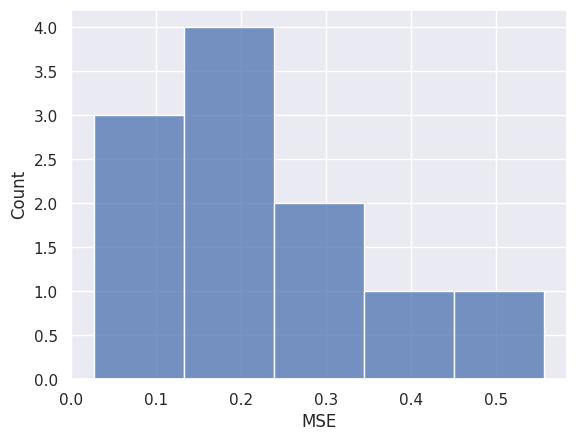

In [97]:
sns.histplot(results["MSE"])

<AxesSubplot: >

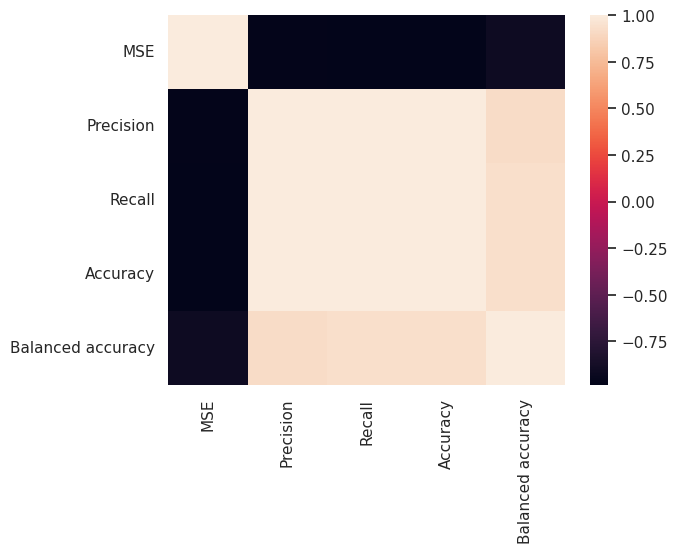

In [98]:
sns.displot()